<h1 align="center">Environmental Sound Classification</h1>

### In continuation of the previous ESC_datapreprocess_US8k.ipynb

### Imports:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os

### Configs, Defining path to fold data (files after feature extraction)

In [2]:
FOLD_DATA_PATH = r"E:\Me\coding\jupyter\Environmental_Sound_Classification\fold_features"
EPOCHS = 100
BATCH_SIZE = 64

### Setting up GPU for computing

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Model Definition 

<p>Reason for choosing ANN:</p> <p>1. “ANN achieved the highest classification accuracy of 95%, outperforming all other deep learning models in urban sound classification.” - [2]</p> <p> 2. A feedforward design with dropout helps prevent overfitting while still capturing the key patterns in the MFCC-based input. </p>

<p>We defined a simple Artificial Neural Network (ANN) using PyTorch to classify environmental sounds into 10 categories. The model takes flattened MFCC features as input (with shape 120×173), processes them through two fully connected (Linear) layers with ReLU activation and dropout for regularization, and outputs predictions via a final linear layer.</p>

In [4]:
# Model definition
class SimpleANN(nn.Module):
    def __init__(self, input_size=120*173, num_classes=10):
        super(SimpleANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [5]:
# 10-fold Cross Validation
accuracies = []

for test_fold in range(1, 11):
    print(f"\n🔁 Fold {test_fold} (test)")

    # Load test fold
    X_test = np.load(os.path.join(FOLD_DATA_PATH, f"X_fold{test_fold}.npy"))
    y_test = np.load(os.path.join(FOLD_DATA_PATH, f"y_fold{test_fold}.npy"))

    # Load training folds (excluding test_fold)
    X_train, y_train = [], []
    for fold in range(1, 11):
        if fold == test_fold:
            continue
        X_part = np.load(os.path.join(FOLD_DATA_PATH, f"X_fold{fold}.npy"))
        y_part = np.load(os.path.join(FOLD_DATA_PATH, f"y_fold{fold}.npy"))
        X_train.append(X_part)
        y_train.append(y_part)

    X_train = np.vstack(X_train)
    y_train = np.hstack(y_train)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

    # Model, Loss, Optimizer
    model = SimpleANN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"  Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    accuracies.append(acc)
    print(f"✅ Fold {test_fold} Accuracy: {acc:.2f}%")

# Average Accuracy
print("\n📊 Average Accuracy over 10 folds:", sum(accuracies) / len(accuracies))


🔁 Fold 1 (test)
  Epoch 1/100 | Loss: 1.3102
  Epoch 2/100 | Loss: 0.8128
  Epoch 3/100 | Loss: 0.5976
  Epoch 4/100 | Loss: 0.4751
  Epoch 5/100 | Loss: 0.4282
  Epoch 6/100 | Loss: 0.3360
  Epoch 7/100 | Loss: 0.3126
  Epoch 8/100 | Loss: 0.2631
  Epoch 9/100 | Loss: 0.2090
  Epoch 10/100 | Loss: 0.2054
  Epoch 11/100 | Loss: 0.1995
  Epoch 12/100 | Loss: 0.1930
  Epoch 13/100 | Loss: 0.1946
  Epoch 14/100 | Loss: 0.1649
  Epoch 15/100 | Loss: 0.1570
  Epoch 16/100 | Loss: 0.1450
  Epoch 17/100 | Loss: 0.1631
  Epoch 18/100 | Loss: 0.1222
  Epoch 19/100 | Loss: 0.1203
  Epoch 20/100 | Loss: 0.0893
  Epoch 21/100 | Loss: 0.0995
  Epoch 22/100 | Loss: 0.0963
  Epoch 23/100 | Loss: 0.0915
  Epoch 24/100 | Loss: 0.1296
  Epoch 25/100 | Loss: 0.1179
  Epoch 26/100 | Loss: 0.1037
  Epoch 27/100 | Loss: 0.1242
  Epoch 28/100 | Loss: 0.1126
  Epoch 29/100 | Loss: 0.1239
  Epoch 30/100 | Loss: 0.1035
  Epoch 31/100 | Loss: 0.0901
  Epoch 32/100 | Loss: 0.0890
  Epoch 33/100 | Loss: 0.1106
  

### Inference and Visualisation

In [6]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

In [7]:
class_labels = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling",
    "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"
]

In [8]:
def preprocess_new_audio(file_path, sr=22050, n_mfcc=120, max_len=173):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)

    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return torch.tensor(mfcc.flatten(), dtype=torch.float32).unsqueeze(0)

In [9]:
def predict_audio(model, file_path, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    input_tensor = preprocess_new_audio(file_path).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)

    return class_labels[predicted.item()], confidence.item()


In [12]:
def visualize_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)

    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()


🎯 Prediction: gun_shot | Confidence: 1.00


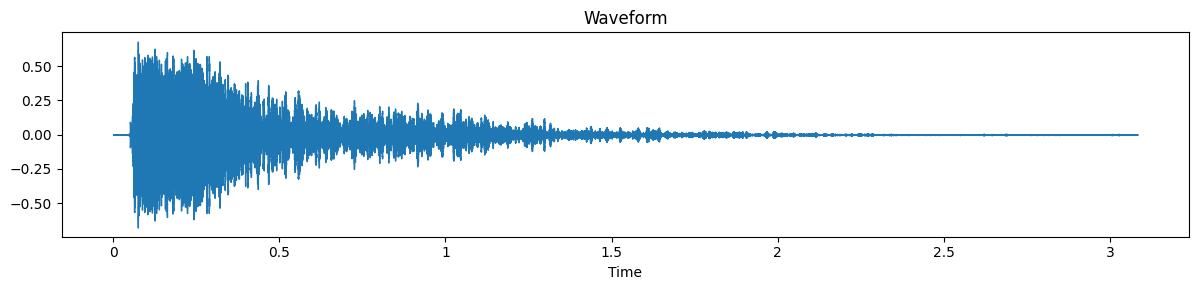

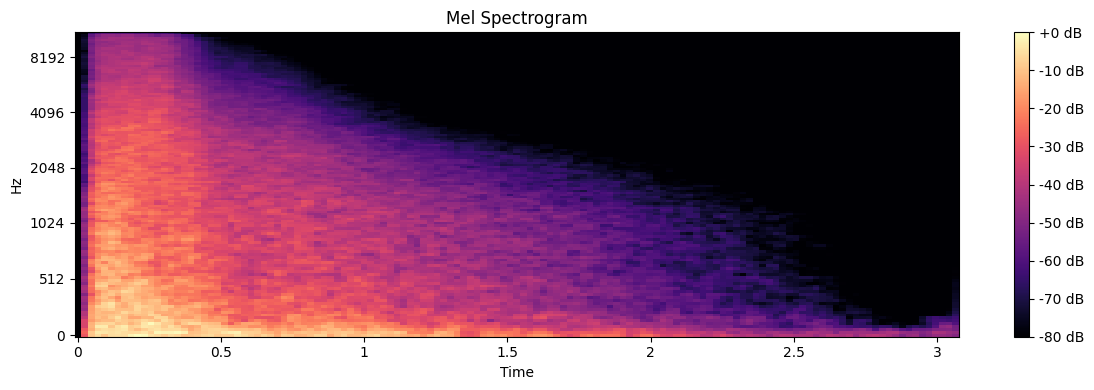

In [15]:
file_path = r"E:\Me\coding\jupyter\Environmental_Sound_Classification\gunshot-372470.mp3"
label, score = predict_audio(model, file_path, device)
print(f"\n🎯 Prediction: {label} | Confidence: {score:.2f}")
visualize_audio(file_path)

### References:

1. J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.
2. Sanjoy Barua, Tahmina Akter, Mahmud Abu Saleh Musa, Muhammad Anwarul Azim . A Deep Learning Approach for Urban Sound Classification. International Journal of Computer Applications. 185, 24 ( Jul 2023), 8-14. DOI=10.5120/ijca2023922991
3. https://www.youtube.com/watch?v=mHPpCXqQd7Y
4. https://www.geeksforgeeks.org/nlp/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/